In [ ]:
import pandas as pd
filepath = 'https://raw.githubusercontent.com/andreagiussani/Applied_Machine_Learning_with_Python/master/data/titanic.csv'
titanic_df = pd.read_csv(filepath)

In [ ]:
# calcolare come si distribuiscono (rispetto alla Pclass variabile) le persone per cui non è stato possibile identificare età.

In [ ]:
bool_condition = titanic_df.Age.isna()
age_is_null_df = titanic_df[bool_condition]

In [ ]:
age_is_null_df.shape

(177, 12)

In [ ]:
age_is_null_df.Age.value_counts()

Series([], Name: Age, dtype: int64)

In [ ]:
age_is_null_df[['Pclass', 'PassengerId']].groupby(['Pclass']).count()

,PassengerId
Pclass,
1,30
2,11
3,136


In [ ]:
age_is_null_df[['Pclass', 'PassengerId', 'Sex']].groupby(['Pclass', 'Sex']).count()

PassengerId
Pclass Sex                
1      female            9
       male             21
2      female            2
       male              9
3      female           42
       male             94

## Imputazione 

scikit-learn
 - transformer: classe che viene usata per fare preprocessing
 - estimator: classe che viene usata per fare fitting

Transformer
 - fit: apprende i pattern nei dati 
 - transform: usare i pattern appresi per fare trasformazione del dato

StandardScaler()

(x - mu)/std

In [ ]:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy='mean')
df_02 = pd.DataFrame(
    si.fit_transform(
        titanic_df[['PassengerId', 'Age']], 
        ),
    columns=['PassengerId', 'AgeImp'])

In [ ]:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy='most_frequent')

In [ ]:
titanic_df.Age.mean()

29.69911764705882

In [ ]:
pd.DataFrame(
    si.fit_transform(
        titanic_df[['PassengerId', 'Survived', 'Cabin']], 
        ),
    columns=['PassengerId', 'Survived', 'Cabin'])
# non ha alcun senso fisico imputare una cabina!

,PassengerId,Survived,Cabin
0,1,0,B96 B98
1,2,1,C85
2,3,1,B96 B98
3,4,1,C123
4,5,0,B96 B98
...,...,...,...
886,887,0,B96 B98
887,888,1,B42
888,889,0,B96 B98
889,890,1,C148


In [ ]:
# Esempio di costante "imputata"
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy='constant', fill_value='No_Cabin')

In [ ]:
df_03 = pd.DataFrame(
    si.fit_transform(
        titanic_df[['PassengerId', 'Cabin']], 
        ),
    columns=['PassengerId', 'CabinImp'])
# non ha alcun senso fisico imputare una cabina!

In [ ]:
titanic_df
df_02
df_03

In [ ]:
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [ ]:
df_02.head(2)

,PassengerId,AgeImp
0,1.0,22.0
1,2.0,38.0


Come posso unire i dataframe?

In [ ]:
titanic_df_imp = titanic_df.merge(
    df_02, on='PassengerId'
).merge(df_03, on='PassengerId'
)

In [ ]:
titanic_df_imp.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeImp,CabinImp
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,27.000000,No_Cabin
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,19.000000,B42
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,29.699118,No_Cabin
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,26.000000,C148
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,32.000000,No_Cabin


## ColumnTransformer

In [ ]:
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(
    [
        ('Age_imp', SimpleImputer(strategy='mean', add_indicator=True), [5]),
        ('Cabin_imp', SimpleImputer(strategy='constant', fill_value='No_Cabin', add_indicator=True), [10]),
    ], remainder= 'passthrough'
)

In [ ]:
imp_df = pd.DataFrame(ct.fit_transform(titanic_df), columns=ct.get_feature_names_out())

In [ ]:
imp_df = imp_df.rename(columns={'Age_imp__Age': 'Age_imp', 'remainder__Fare': 'Fare'})
imp_df.tail(3)

,Age_imp,Age_imp__missingindicator_Age,Cabin_imp__Cabin,Cabin_imp__missingindicator_Cabin,remainder__PassengerId,remainder__Survived,remainder__Pclass,remainder__Name,remainder__Sex,remainder__SibSp,remainder__Parch,remainder__Ticket,Fare,remainder__Embarked
888,29.699118,1.0,No_Cabin,True,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,1,2,W./C. 6607,23.45,S
889,26.0,0.0,C148,False,890,1,1,"Behr, Mr. Karl Howell",male,0,0,111369,30.0,C
890,32.0,0.0,No_Cabin,True,891,0,3,"Dooley, Mr. Patrick",male,0,0,370376,7.75,Q


## Matplotlib

In [ ]:
titanic_df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


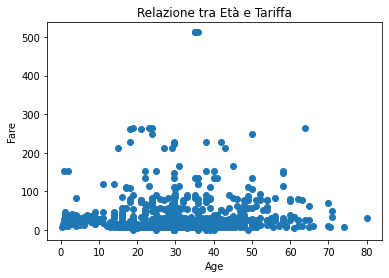

In [ ]:
%matplotlib inline 
# jupyter notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# ax.plot(imp_df['Age_imp'], imp_df['Fare'], marker='*', linestyle='None')
ax.scatter(imp_df['Age_imp'], imp_df['Fare'])
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.set_title('Relazione tra Età e Tariffa')
plt.show()

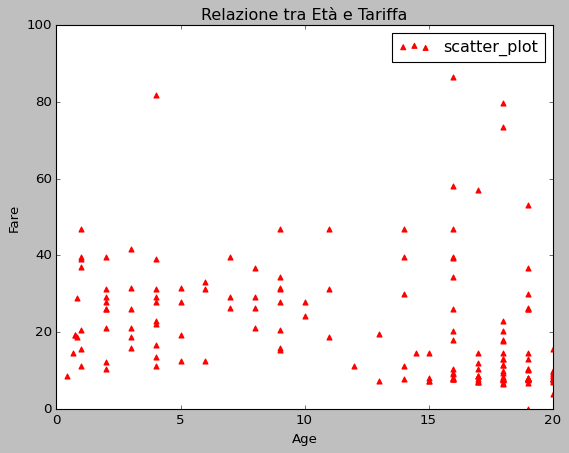

In [ ]:
%matplotlib inline 
# jupyter notebook
import matplotlib.pyplot as plt
import matplotlib.style 
import matplotlib as mpl
mpl.style.use('classic')

fig, ax = plt.subplots()
# ax.plot(imp_df['Age_imp'], imp_df['Fare'], marker='*', linestyle='None')
ax.scatter(imp_df['Age_imp'], imp_df['Fare'], color='r', marker="^", label='scatter_plot')
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.set_title('Relazione tra Età e Tariffa')
ax.set_xlim([0, 20])
ax.set_ylim([0, 100])
ax.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


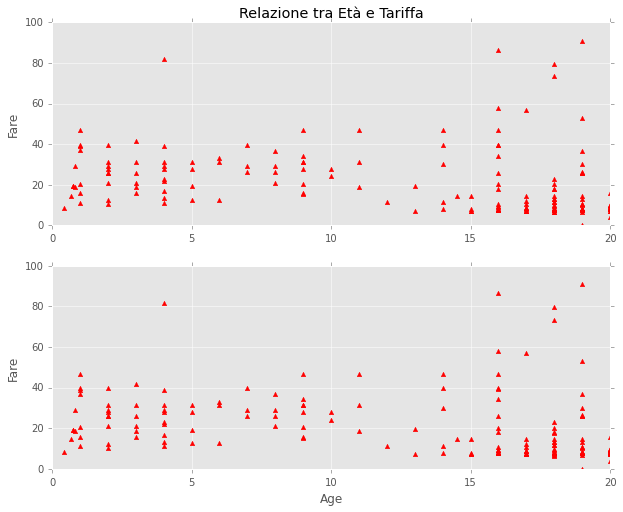

In [ ]:
%matplotlib inline 
# jupyter notebook
import matplotlib.pyplot as plt
import matplotlib.style 
import matplotlib as mpl
mpl.style.use('ggplot')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
# ax.plot(imp_df['Age_imp'], imp_df['Fare'], marker='*', linestyle='None')
ax[0].scatter(imp_df['Age_imp'], imp_df['Fare'], color='r', marker="^", label='scatter_plot')
ax[1].scatter(imp_df['Age_imp'], imp_df['Fare'], color='r', marker="^", label='scatter_plot2')
ax[1].set_xlabel('Age')
ax[0].set_ylabel('Fare')
ax[1].set_ylabel('Fare')
ax[0].set_title('Relazione tra Età e Tariffa')
ax[0].set_xlim([0, 20])
ax[0].set_ylim([0, 100])
ax[1].set_xlim([0, 20])
ax[1].set_ylim([0, 100])
#ax.legend()
plt.savefig('/content/drive/MyDrive/IULM/PhD course/my_plot.png')
plt.show()

In [ ]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
titanic_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
df_new = titanic_df['Pclass'].value_counts().reset_index()

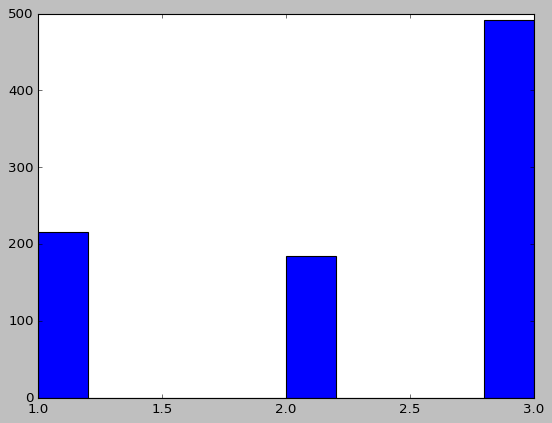

In [ ]:
%matplotlib inline 
# jupyter notebook
import matplotlib.pyplot as plt
import matplotlib.style 
import matplotlib as mpl
mpl.style.use('classic')

fig, ax = plt.subplots()
ax.hist(titanic_df['Pclass'])
plt.show()